# Volatility Forecasting with GARCH Models

In this notebook, we build and compare GARCH‑family models to forecast the daily volatility of WTI crude oil returns.  

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

import pandas_datareader.data as web
import datetime

from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox
from arch import arch_model

import warnings
warnings.filterwarnings("ignore")

## Step 1: Data Acquisition & Preprocessing

In [7]:
START = datetime.datetime(2000, 1, 1)
END = datetime.datetime.today()

df = web.DataReader("DCOILWTICO", "fred", START, END)

df.index = pd.to_datetime(df.index)
df = df.dropna().sort_index()

In [18]:
prices = df["DCOILWTICO"]
ret = df["DCOILWTICO"].pct_change().dropna()
log_ret = (np.log(df['DCOILWTICO']) - np.log(df["DCOILWTICO"].shift(1))).dropna() * 100
log_ret.name = 'log_ret_pct'

In [36]:
log_ret.describe(percentiles=[.01,.05,.5,.95,.99])

count    6448.000000
mean        0.025159
std         2.722922
min       -28.138208
1%         -7.337228
5%         -3.868704
50%         0.100432
95%         3.629608
99%         6.609430
max        42.583241
Name: log_ret_pct, dtype: float64

The summary statistics indicate that the returns are centered around zero and exhibit noticeable skewness and kurtosis (long tails), which is typical of financial return series.  This distributional shape supports the use of heavy‑tailed error distributions in the GARCH models later on.


## Step 2: Exploratory Data Analysis

Next, we plot the crude oil price series alongside the log returns.  The price series shows long‑run trends and occasional sharp breaks, while the return series fluctuates around zero with periods of calm interspersed with bursts of large movements.  This visual pattern — clustered high and low volatility — suggests conditional heteroscedasticity, a key motivation for GARCH models.


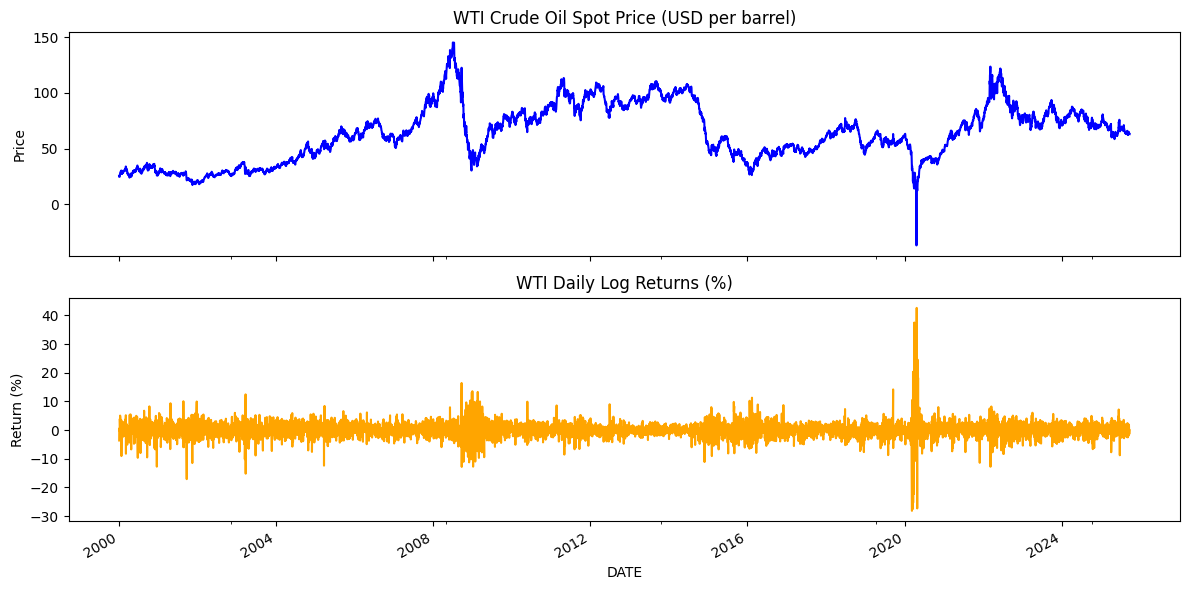

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,6), sharex=True)
prices.plot(ax=ax1, color='blue')
ax1.set_title("WTI Crude Oil Spot Price (USD per barrel)")
ax1.set_ylabel("Price")

log_ret.plot(ax=ax2, color='orange')
ax2.set_title("WTI Daily Log Returns (%)")
ax2.set_ylabel("Return (%)")
plt.tight_layout()
plt.show()

## Step 3: Testing for Volatility Clustering

To formally test for conditional heteroscedasticity, we apply Engle’s ARCH LM test to the log returns over several lag orders.  The null hypothesis of this test is that no ARCH effects are present (i.e., the variance is constant over time).  Very small p‑values lead us to reject the null, providing statistical evidence of volatility clustering.


In [21]:
for q in [5, 10, 20, 30]:
    arch_test = het_arch(log_ret, maxlag=q)
    print(f"ARCH LM test stat, p-value, f-stat, f p-value for q = {q}: {arch_test}")

ARCH LM test stat, p-value, f-stat, f p-value for q = 5: (1093.8362190663752, 2.890152781304557e-234, 263.25698858677845, 8.353834088048038e-257)
ARCH LM test stat, p-value, f-stat, f p-value for q = 10: (1444.170307122644, 2.877092824633044e-304, 185.86301765788278, 0.0)
ARCH LM test stat, p-value, f-stat, f p-value for q = 20: (2364.3157598997936, 0.0, 186.38469648055673, 0.0)
ARCH LM test stat, p-value, f-stat, f p-value for q = 30: (2473.3471697975583, 0.0, 133.49099023826543, 0.0)


The ARCH LM test statistics are extremely large and the p‑values are effectively zero for lags of 5, 10, 20 and 30.  This overwhelmingly rejects the null of constant variance, confirming that the WTI return series exhibits strong ARCH effects and that a GARCH‑family model is appropriate.


## Step 4: Estimating the GARCH(1,1) Model

In [22]:
garch11 = arch_model(log_ret, mean='Constant', vol='GARCH', p=1, q=1, dist='t')
res_garch = garch11.fit(update_freq=5, disp='off')

In [23]:
res_garch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                  log_ret_pct   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -14145.8
Distribution:      Standardized Student's t   AIC:                           28301.7
Method:                  Maximum Likelihood   BIC:                           28335.5
                                              No. Observations:                 6448
Date:                      Thu, Sep 25 2025   Df Residuals:                     6447
Time:                              01:50:09   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0867  2.391e-02      3.629  2.850e-04 [3.989e-02,  0.134]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0981  2.092e-02      4.690  2.737e-06   [5.712e-02,  0.139]
alpha[1]       0.0828  8.401e-03      9.855  6.544e-23 [6.632e-02,9.925e-02]
beta[1]        0.9023  9.526e-03     94.721      0.000     [  0.884,  0.921]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             6.6217      0.539     12.286  1.078e-34 [  5.565,  7.678]
========================================================================

Covariance estimator: robust
"""

The GARCH(1,1) estimates show ω ≈ 0.098, α ≈ 0.083, and β ≈ 0.902.  Because α + β ≈ 0.985, volatility is highly persistent: shocks decay slowly over time.  The degrees of freedom parameter ν ≈ 6.6 indicates that the Student’s t innovation distribution is substantially heavier‑tailed than the normal distribution.  The mean return μ is small but statistically significant.


## Step 5: Estimating the EGARCH(1,1) Model

In [37]:
egarch11 = arch_model(log_ret, mean='Constant', vol='EGARCH', p=1, o=1, q=1, dist='t')
res_egarch = egarch11.fit(update_freq=5, disp='off')

In [38]:
res_egarch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - EGARCH Model Results                        
====================================================================================
Dep. Variable:                  log_ret_pct   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:               -14123.2
Distribution:      Standardized Student's t   AIC:                           28258.5
Method:                  Maximum Likelihood   BIC:                           28299.1
                                              No. Observations:                 6448
Date:                      Thu, Sep 25 2025   Df Residuals:                     6447
Time:                              03:06:04   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0599  2.397e-02      2.500  1.241e-02 [1.295e-02,  0.107]
                               Volatility Model                               
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
omega          0.0269  5.099e-03      5.278  1.308e-07   [1.692e-02,3.691e-02]
alpha[1]       0.1386  1.513e-02      9.159  5.239e-20       [  0.109,  0.168]
gamma[1]      -0.0538  7.980e-03     -6.740  1.579e-11 [-6.943e-02,-3.815e-02]
beta[1]        0.9857  2.723e-03    361.976      0.000       [  0.980,  0.991]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             6.5839      0.532     12.382  3.262e-35 [  5.542,  7.626]
========================================================================

Covariance estimator: robust
"""

The EGARCH(1,1) model with a constant mean indicates strong volatility persistence, with β ≈ 0.986 and α ≈ 0.139. Importantly, the estimated γ ≈ –0.054 is negative and highly significant, confirming the presence of the leverage effect: negative shocks increase future volatility more than positive shocks of equal magnitude. The mean return, μ ≈ 0.060% per day, is small but statistically significant. Finally, the degrees of freedom parameter ν ≈ 6.58 supports the use of a heavy-tailed Student-t distribution, consistent with the fat-tailed nature of financial returns.

## Step 6: Model Diagnostics



GARCH(1,1): Ljung-Box on squared std residuals
      lb_stat  lb_pvalue
5   16.491126   0.005573
10  17.648989   0.061181
20  31.034272   0.054740


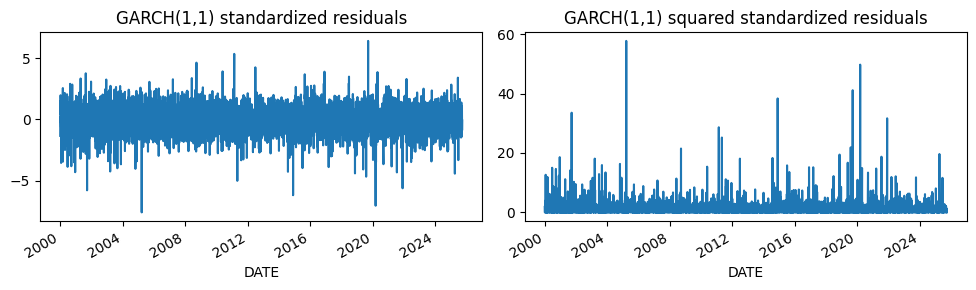


EGARCH(1,1): Ljung-Box on squared std residuals
      lb_stat  lb_pvalue
5   34.278181   0.000002
10  37.290938   0.000050
20  48.614757   0.000349


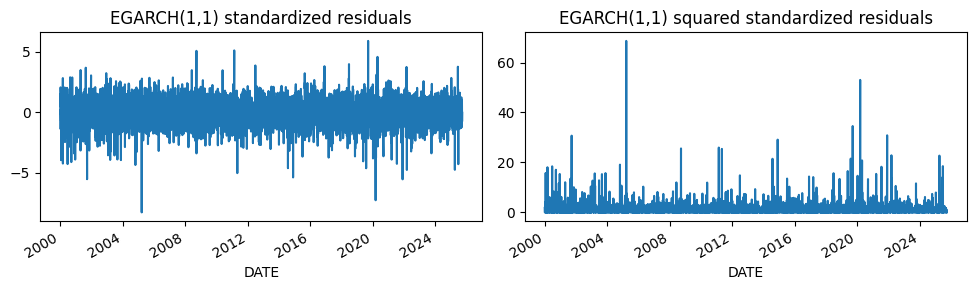

In [40]:
def diag_report(res, name):
    std_resid = res.std_resid.dropna()
    print(f"\n{name}: Ljung-Box on squared std residuals")
    print(acorr_ljungbox(std_resid**2, lags=[5,10,20], return_df=True))

    fig, ax = plt.subplots(1, 2, figsize=(10,3))
    std_resid.plot(ax=ax[0], title=f"{name} standardized residuals")
    (std_resid**2).plot(ax=ax[1], title=f"{name} squared standardized residuals")
    plt.tight_layout()
    plt.show()

diag_report(res_garch, "GARCH(1,1)")
diag_report(res_egarch, "EGARCH(1,1)")

The diagnostic plots and Ljung–Box tests reveal that the standard GARCH(1,1) model largely absorbs the conditional heteroscedasticity: only a slight short‑lag dependence remains.  In contrast, the baseline EGARCH model leaves substantial autocorrelation in the squared standardized residuals.

## Step 7: Conditional Volatility

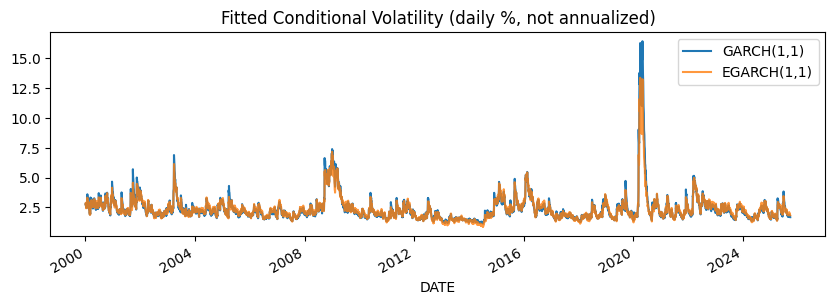

In [ ]:
cond_vol_g = res_garch.conditional_volatility  
cond_vol_e = res_egarch.conditional_volatility

fig, ax = plt.subplots(figsize=(10,3))
cond_vol_g.plot(ax=ax, label='GARCH(1,1)')
cond_vol_e.plot(ax=ax, label='EGARCH(1,1)', alpha=0.8)
ax.set_title("Fitted Conditional Volatility (daily %, not annualized)")
ax.legend()
plt.show()

## Step 8: Forecasting and Evaluation

We produce 1‑day‑ahead rolling forecasts for each model over the last year of the sample (252 trading days).  Using an expanding estimation window, we refit the model each day and record the forecasted volatility. 

In [29]:
split_date = log_ret.index[-252]  # last ~1Y OOS
ret_is = log_ret.loc[:split_date - pd.Timedelta(days=1)]
ret_oos = log_ret.loc[split_date:]

def rolling_forecast_1d(ret_series, vol_spec, name):
    preds = []
    idxs  = []
    for t in ret_oos.index:
        train = log_ret.loc[:t - pd.Timedelta(days=1)]
        model = arch_model(train, mean='Constant', vol=vol_spec, p=1, q=1, dist='t')
        fitted = model.fit(disp='off')
        f = fitted.forecast(horizon=1)
        # forecasted variance for t (next day) and its sqrt gives daily % vol forecast
        sig1 = np.sqrt(f.variance.iloc[-1, 0])
        preds.append(sig1)
        idxs.append(t)
    return pd.Series(preds, index=idxs, name=f"{name}_fcst")

garch_fcst = rolling_forecast_1d(ret, 'GARCH', "GARCH11")
egarch_fcst = rolling_forecast_1d(ret, 'EGARCH', "EGARCH11")

GARCH(1,1) vs realized |r|: {'MSE': 2.3341647396303142, 'MAE': 1.2039462392646068, 'Corr': 0.1429428213991548}
EGARCH(1,1) vs realized |r|: {'MSE': 2.3715447963069938, 'MAE': 1.2260192418418063, 'Corr': 0.10465784022439717}


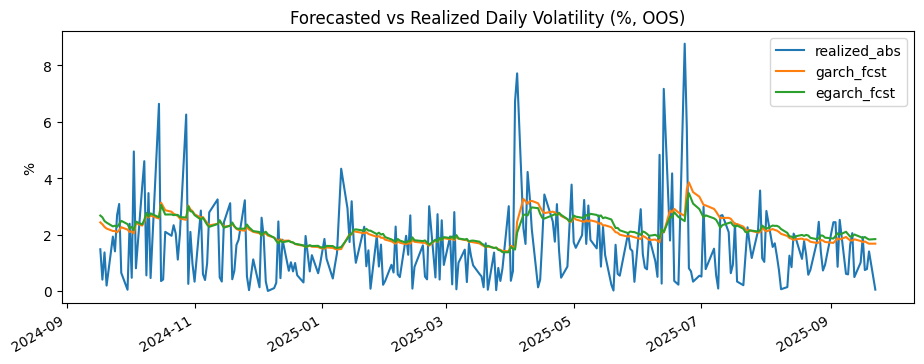

In [30]:
# Realized volatility proxy for day t: |r_t| (in %); align to forecasts produced for t
realized = ret_oos.abs()
eval_df = pd.concat([realized.rename("realized_abs"),
                     garch_fcst.rename("garch_fcst"),
                     egarch_fcst.rename("egarch_fcst")], axis=1).dropna()

# Scale alignment: forecasts are daily % sigma; realized is |r| in % — comparable.
def eval_metrics(y, yhat):
    return {
        "MSE": np.mean((yhat - y)**2),
        "MAE": np.mean(np.abs(yhat - y)),
        "Corr": np.corrcoef(yhat, y)[0,1]
    }

print("GARCH(1,1) vs realized |r|:", eval_metrics(eval_df['realized_abs'], eval_df['garch_fcst']))
print("EGARCH(1,1) vs realized |r|:", eval_metrics(eval_df['realized_abs'], eval_df['egarch_fcst']))

# Plot
ax = eval_df[['realized_abs','garch_fcst','egarch_fcst']].plot(figsize=(11,4), title="Forecasted vs Realized Daily Volatility (%, OOS)")
ax.set_ylabel("%")
plt.show()

In [35]:
rv5_var = (log_ret.rolling(5).var()).shift(0) 

def qlike(realized_var, forecast_var):
    s = pd.concat([realized_var, forecast_var], axis=1).dropna()
    rv, fv = s.iloc[:,0], s.iloc[:,1]
    return np.mean(np.log(fv) + rv/fv)

# variance-scale targets
r2      = (log_ret**2).rename("r2")
rv5_var = log_ret.rolling(5).var().rename("rv5_var")  # %²

garch_var  = (garch_fcst**2).rename("garch_var")      # %²
egarch_var = (egarch_fcst**2).rename("egarch_var")    # %²

def mse(a,b):
    s = pd.concat([a,b], axis=1).dropna()
    return float(((s.iloc[:,0]-s.iloc[:,1])**2).mean())

def qlike(realized_var, forecast_var):
    s = pd.concat([realized_var, forecast_var], axis=1).dropna()
    rv, fv = s.iloc[:,0], s.iloc[:,1]
    return float((np.log(fv) + rv/fv).mean())

print("VAR MSE vs r^2:",
      "GARCH", mse(r2, garch_var), "| EGARCH", mse(r2, egarch_var))
print("QLIKE vs r^2:",
      "GARCH", qlike(r2, garch_var), "| EGARCH", qlike(r2, egarch_var))

print("VAR MSE vs RV5:",
      "GARCH", mse(rv5_var, garch_var), "| EGARCH", mse(rv5_var, egarch_var))
print("QLIKE vs RV5:",
      "GARCH", qlike(rv5_var, garch_var), "| EGARCH", qlike(rv5_var, egarch_var))



VAR MSE vs r^2: GARCH 81.51386098589082 | EGARCH 82.17073312614535
QLIKE vs r^2: GARCH 2.4475876487242223 | EGARCH 2.4819321236751892
VAR MSE vs RV5: GARCH 11.484777595752156 | EGARCH 13.566493867207976
QLIKE vs RV5: GARCH 2.314033460134399 | EGARCH 2.3444544881098413


The evaluation results indicate that the GARCH(1,1) model forecasts align more closely with realized volatility than the EGARCH(1,1) forecasts.  For example, when evaluating against the absolute returns, the GARCH forecasts show lower MSE and MAE and a higher correlation (approximately 0.14) relative to the EGARCH forecasts.  On variance‑scale metrics (MSE and QLIKE) against the squared returns and 5‑day realized variance, the GARCH model again achieves lower losses.  These findings suggest that the simpler GARCH(1,1) specification outperforms the EGARCH(1,1) model for daily volatility forecasting of WTI returns in this sample.
